<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/03_modelo_con_categoricas_ciclicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Conv 1D**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

**Notebook: Manuel Sánchez-Montañés**

**Datos: Carlos Rosado**

Librería data augmentation en series temporales:

https://github.com/uchidalab/time_series_augmentation

https://github.com/uchidalab/time_series_augmentation/blob/master/docs/AugmentationMethods.md

Notebook con ejemplos:
https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

In [1]:
COLAB = True

In [2]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='135Md8L6aQhteU6y96uct86spAT89HqNJ',
                                        dest_path='./datos_pasajeros.csv')
    gdd.download_file_from_google_drive(file_id='12-N_wA3ZU5T3U64XnY0EIImxE3FkTgv6',
                                        dest_path='./my_utils_series_temporales.py')
    !pip install h5py==2.10.0
    # https://github.com/uchidalab/time_series_augmentation
    # https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

    !pip install gitdir
    !gitdir https://github.com/uchidalab/time_series_augmentation/tree/master/utils

     |████████████████████████████████| 2.9 MB 25.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Created wheel for gitdir: filename=gitdir-1.2.5-py3-none-any.whl size=5654 sha256=850c2906c319ee2f7082db4dc949a92ae037c50aba91b6fa22c1ccc18f14d368
  Stored in directory: /root/.cache/pip/wheels/76/e5/f1/8738f8701ec0cc0b08553b29e63a99a9687f4339e9de5d5c57
Successfully built gitdir
Downloaded: augmentation.py
Downloaded: datasets.py
Downloaded: dtw.py
Downloaded: helper.py
Downloaded: input_data.py
Downloaded: models.py
Downloaded: nemenyi.py
Downloaded: prototype_selection.py
✔ Download complete


In [3]:
!ls utils

augmentation.py  dtw.py     input_data.py  nemenyi.py
datasets.py	 helper.py  models.py	   prototype_selection.py


In [4]:
import utils.augmentation as aug

## <font color="#CA3532"> **1. Importar librerías**

In [5]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [6]:
data = pd.read_csv('datos_pasajeros.csv')
data.head(20)

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
0,2015-01-01,1,1,1125,0,3
1,2015-01-02,1,0,3592,0,4
2,2015-01-03,1,0,3001,0,5
3,2015-01-04,1,0,2260,0,6
4,2015-01-05,1,0,2767,0,0
5,2015-01-06,1,1,1342,0,1
6,2015-01-07,1,0,3867,0,2
7,2015-01-08,1,0,3904,1,3
8,2015-01-09,1,0,3678,1,4
9,2015-01-10,1,0,2631,1,5


In [7]:
data.shape

(790, 6)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [8]:
type(data['fecha'][0])

str

In [9]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['fecha'] = pd.to_datetime(data['fecha'])
type(data['fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
data['fecha']

0     2015-01-01
1     2015-01-02
2     2015-01-03
3     2015-01-04
4     2015-01-05
         ...    
785   2017-02-24
786   2017-02-25
787   2017-02-26
788   2017-02-27
789   2017-02-28
Name: fecha, Length: 790, dtype: datetime64[ns]

In [11]:
fechas      = data['fecha'].values
target      = data['npasajeros'].values
mes         = data['mes'].values
festivo     = data['festivo'].values
semana      = data['semana_mes'].values
day_of_week = data['day_of_week'].values

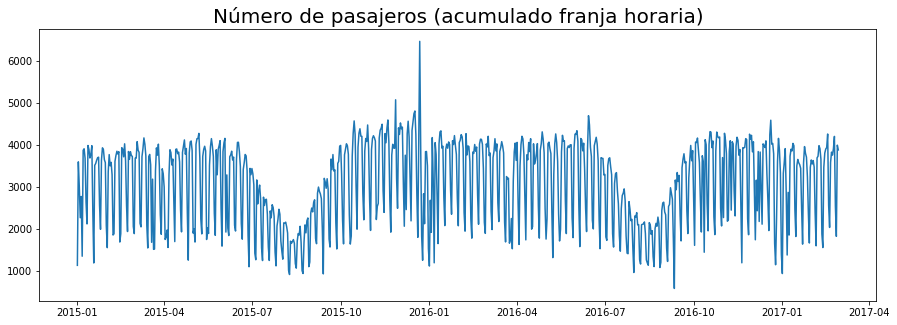

In [12]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Número de pasajeros (acumulado franja horaria)',
          fontsize=20);

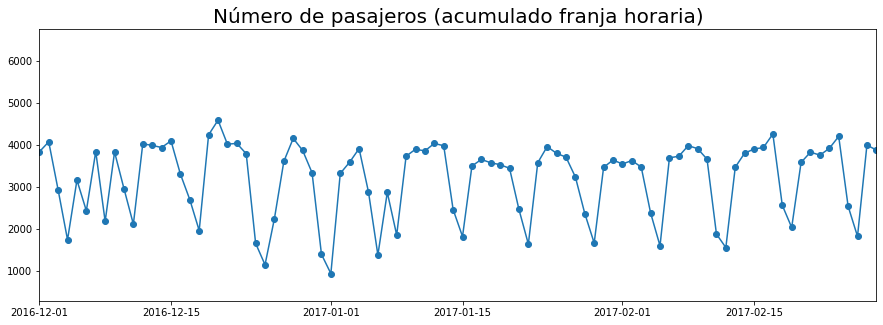

In [13]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Número de pasajeros (acumulado franja horaria)', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

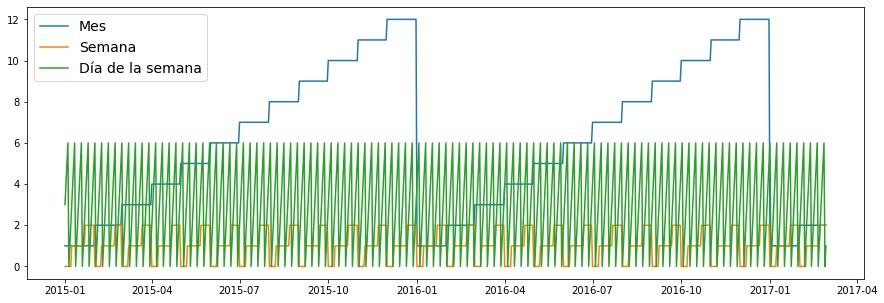

In [14]:
plt.figure(figsize=(15,5))
plt.plot(fechas, mes, label='Mes')
plt.plot(fechas, semana, label='Semana')
plt.plot(fechas, day_of_week, label='Día de la semana')
plt.legend(fontsize=14);

La distancia de dciembre a enero es muy grande, no reresenta la realidad.

Media número de viajeros    : 3065.5784810126584


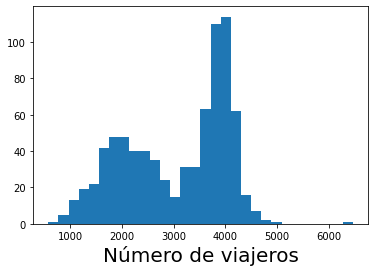

In [15]:
plt.hist(target, bins=30)
plt.xlabel('Número de viajeros', fontsize=20)
print("Media número de viajeros    :", target.mean())

## <font color="#CA3532"> **4. Transformación de la variable a predecir**

In [16]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/5000
def inverse_transform(x_escalado):
    return x_escalado*5000

In [17]:
transform(np.array([1,2,3]))

array([0.0002, 0.0004, 0.0006])

## <font color="#CA3532"> **5. Enventanado de datos**

In [18]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

**Otra posible estrategia** para tratar cada variable categórica cíclica es mapearla sobre el círculo de radio unidad, obteniendo así solo 2 coordenadas por variable categórica cíclica.

`coord_x_mes = np.cos((MES-1)/12 * 2*np.pi)  # MES va de 1 a 12`

`coord_y_mes = np.sin((MES-1)/12 * 2*np.pi)  # MES va de 1 a 12`


\\


`coord_x_dia = np.cos(DIA_SEMANA/7 * 2*np.pi)  # DIA_SEMANA va de 0 a 6`

`coord_y_dia = np.sin(DIA_SEMANA/7 * 2*np.pi)  # DIA_SEMANA va de 0 a 6`

In [19]:
def encode_ciclicas(v, n_valores):
    x = np.cos(v/n_valores * 2*np.pi)
    y = np.sin(v/n_valores * 2*np.pi)
    return x, y

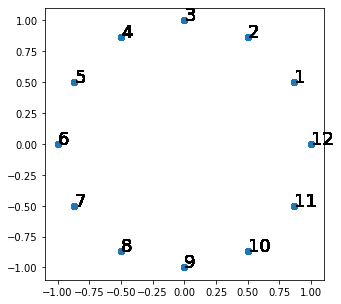

In [20]:
coords_x_mes, coords_y_mes = encode_ciclicas(mes, 12)
plt.figure(figsize=(5,5))
plt.plot(coords_x_mes, coords_y_mes, "o")
for cx,cy,texto in zip(coords_x_mes, coords_y_mes, mes):
    plt.text(cx,cy,texto, fontsize=18)

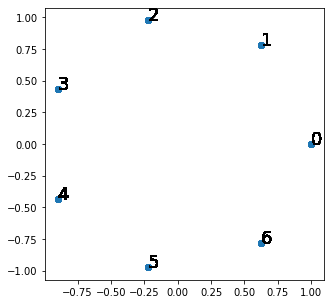

In [21]:
coords_x_day_of_week, coords_y_day_of_week = encode_ciclicas(day_of_week, 7)
plt.figure(figsize=(5,5))
plt.plot(coords_x_day_of_week, coords_y_day_of_week, "o")
for cx,cy,texto in zip(coords_x_day_of_week, coords_y_day_of_week, day_of_week):
    plt.text(cx,cy,texto, fontsize=18)

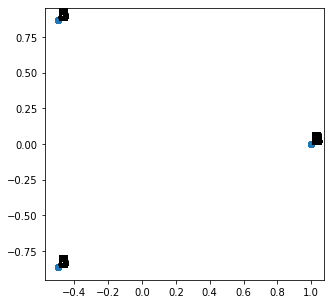

In [22]:
coords_x_semana, coords_y_semana = encode_ciclicas(semana, 3)
plt.figure(figsize=(5,5))
plt.plot(coords_x_semana, coords_y_semana, "o")
for cx,cy,texto in zip(coords_x_semana, coords_y_semana, day_of_week):
    plt.text(cx,cy,texto, fontsize=18)

In [23]:
target_transf = transform(target)

series = [target_transf, festivo]
se_saben_antes = [False, True]
nombres_series = ["target_transf", "festivo"]

# Variables calendario sobre las que hemos la transformación cíclica
series.append(coords_x_mes)
nombres_series.append("coords_x_mes")
se_saben_antes.append(True)

series.append(coords_y_mes)
nombres_series.append("coords_y_mes")
se_saben_antes.append(True)

series.append(coords_x_semana)
nombres_series.append("coords_x_semana")
se_saben_antes.append(True)

series.append(coords_y_semana)
nombres_series.append("coords_y_semana")
se_saben_antes.append(True)

series.append(coords_x_day_of_week)
nombres_series.append("coords_x_day_of_week")
se_saben_antes.append(True)

series.append(coords_y_day_of_week)
nombres_series.append("coords_y_day_of_week")
se_saben_antes.append(True)

Ha reducido el num de variable sde entrada de 24 a 8.

In [ ]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(8, 790)
(8,)


In [ ]:
lookback = 5 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(790, 5, 8) (790,)


In [ ]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 5, 8)  Y.shape=(10,) 

 Ventana 0: 


X[0].shape=(5, 8) ?0 ?1 ?2 ?3 ?4 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 festivo 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 nan 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 nan 
 0.500000 
 
 
 coords_x_semana 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 
 
 coords_y_semana 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 
 
 coords_x_day_of_week 
 nan 
 nan 
 nan 
 nan 
 -0.900969 
 
 
 coords_y_day_of_week 
 nan 
 nan 
 nan 
 nan 
 0.433884 
 
 __ Y[0]=0.225 2015-01-01 00:00:00 
 
 target 
 0.225000

 Ventana 1: 


X[1].shape=(5, 8) ?0 ?1 ?2 ?3 2015-01-01T00:00:00.000000000 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 
 
 festivo 
 nan 
 nan 
 nan 
 1.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 nan 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 nan 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 nan 
 nan 
 nan 
 1.000000 
 1.000000 
 
 
 coords_y_semana 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 
 
 coords_x_day_of_week 
 nan 
 nan 
 nan 
 -0.900969 
 -0.900969 
 
 
 coords_y_day_of_week 
 nan 
 nan 
 nan 
 0.433884 
 -0.433884 
 
 __ Y[1]=0.7184 2015-01-02 00:00:00 
 
 target 
 0.718400

 Ventana 2: 


X[2].shape=(5, 8) ?0 ?1 ?2 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 
 
 target_transf 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 
 
 festivo 
 nan 
 nan 
 1.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 nan 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 nan 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 nan 
 nan 
 1.000000 
 1.000000 
 1.000000 
 
 
 coords_y_semana 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_day_of_week 
 nan 
 nan 
 -0.900969 
 -0.900969 
 -0.222521 
 
 
 coords_y_day_of_week 
 nan 
 nan 
 0.433884 
 -0.433884 
 -0.974928 
 
 __ Y[2]=0.6002 2015-01-03 00:00:00 
 
 target 
 0.600200

 Ventana 3: 


X[3].shape=(5, 8) ?0 ?1 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 2015-01-03T00:00:00.000000000 
 
 target_transf 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 
 
 festivo 
 nan 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 nan 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 nan 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 nan 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 
 
 coords_y_semana 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_day_of_week 
 nan 
 -0.900969 
 -0.900969 
 -0.222521 
 0.623490 
 
 
 coords_y_day_of_week 
 nan 
 0.433884 
 -0.433884 
 -0.974928 
 -0.781831 
 
 __ Y[3]=0.452 2015-01-04 00:00:00 
 
 target 
 0.452000

 Ventana 4: 


X[4].shape=(5, 8) ?0 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 2015-01-03T00:00:00.000000000 2015-01-04T00:00:00.000000000 
 
 target_transf 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 
 
 festivo 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 
 
 coords_y_semana 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_day_of_week 
 -0.900969 
 -0.900969 
 -0.222521 
 0.623490 
 1.000000 
 
 
 coords_y_day_of_week 
 0.433884 
 -0.433884 
 -0.974928 
 -0.781831 
 0.000000 
 
 __ Y[4]=0.5534 2015-01-05 00:00:00 
 
 target 
 0.553400

 Ventana 5: 


X[5].shape=(5, 8) 2015-01-01 00:00:00 2015-01-02 00:00:00 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 
 
 target_transf 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 
 
 festivo 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 
 
 coords_x_mes 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 
 
 coords_y_semana 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_day_of_week 
 -0.900969 
 -0.222521 
 0.623490 
 1.000000 
 0.623490 
 
 
 coords_y_day_of_week 
 -0.433884 
 -0.974928 
 -0.781831 
 0.000000 
 0.781831 
 
 __ Y[5]=0.2684 2015-01-06 00:00:00 
 
 target 
 0.268400

 Ventana 6: 


X[6].shape=(5, 8) 2015-01-02 00:00:00 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 
 
 target_transf 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 
 
 festivo 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 0.000000 
 
 
 coords_x_mes 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 
 
 coords_y_semana 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_day_of_week 
 -0.222521 
 0.623490 
 1.000000 
 0.623490 
 -0.222521 
 
 
 coords_y_day_of_week 
 -0.974928 
 -0.781831 
 0.000000 
 0.781831 
 0.974928 
 
 __ Y[6]=0.7734 2015-01-07 00:00:00 
 
 target 
 0.773400

 Ventana 7: 


X[7].shape=(5, 8) 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 
 
 target_transf 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 
 
 festivo 
 0.000000 
 0.000000 
 1.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 -0.500000 
 
 
 coords_y_semana 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.866025 
 
 
 coords_x_day_of_week 
 0.623490 
 1.000000 
 0.623490 
 -0.222521 
 -0.900969 
 
 
 coords_y_day_of_week 
 -0.781831 
 0.000000 
 0.781831 
 0.974928 
 0.433884 
 
 __ Y[7]=0.7808 2015-01-08 00:00:00 
 
 target 
 0.780800

 Ventana 8: 


X[8].shape=(5, 8) 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 2015-01-08 00:00:00 
 
 target_transf 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 
 
 festivo 
 0.000000 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 1.000000 
 1.000000 
 1.000000 
 -0.500000 
 -0.500000 
 
 
 coords_y_semana 
 0.000000 
 0.000000 
 0.000000 
 0.866025 
 0.866025 
 
 
 coords_x_day_of_week 
 1.000000 
 0.623490 
 -0.222521 
 -0.900969 
 -0.900969 
 
 
 coords_y_day_of_week 
 0.000000 
 0.781831 
 0.974928 
 0.433884 
 -0.433884 
 
 __ Y[8]=0.7356 2015-01-09 00:00:00 
 
 target 
 0.735600

 Ventana 9: 


X[9].shape=(5, 8) 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 2015-01-08 00:00:00 2015-01-09 00:00:00 
 
 target_transf 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 0.735600 
 
 
 festivo 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_y_mes 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 0.500000 
 
 
 coords_x_semana 
 1.000000 
 1.000000 
 -0.500000 
 -0.500000 
 -0.500000 
 
 
 coords_y_semana 
 0.000000 
 0.000000 
 0.866025 
 0.866025 
 0.866025 
 
 
 coords_x_day_of_week 
 0.623490 
 -0.222521 
 -0.900969 
 -0.900969 
 -0.222521 
 
 
 coords_y_day_of_week 
 0.781831 
 0.974928 
 0.433884 
 -0.433884 
 -0.974928 
 
 __ Y[9]=0.5262 2015-01-10 00:00:00 
 
 target 
 0.526200

In [ ]:
print(X.shape)
print(np.shape(target))

(790, 5, 8)
(790,)


## <font color="#CA3532"> **6. Separación training-test**

In [ ]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [ ]:
X_train      = X[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(627,)
(158,)


In [ ]:
print(X_train.shape, y_train.shape)

(627, 5, 8) (627,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [ ]:
loss = 'mean_squared_error'

optimizer = "adam"
optimizer="rmsprop"
#optimizer=Adam(learning_rate=0.01), # más rápido

model = Sequential()
model.add(Conv1D(4, kernel_size=3, activation="relu", input_shape=(lookback, X_train.shape[-1])))
model.add(Conv1D(4, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(1, # kernel_regularizer='l1'
               )
         )
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [ ]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 4)              100       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 4)              52        
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


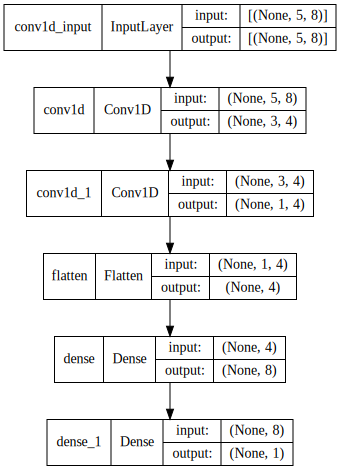

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


Epoch 00001: val_mse improved from inf to 0.00578, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00578

Epoch 00001: val_mse did not improve from 0.00578

Epoch 00001: val_mse did not improve from 0.00578

Epoch 00001: val_mse did not improve from 0.00578

Epoch 00001: val_mse improved from 0.00578 to 0.00546, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00546

Epoch 00001: val_mse improved from 0.00546 to 0.00521, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00521

Epoch 00001: val_mse did not improve from 0.00521

Epoch 00001: val_mse did not improve from 0.00521

Epoch 00001: val_mse did not improve from 0.00521

Epoch 00001: val_mse did not improve from 0.00521

Epoch 00001: val_mse did not improve from 0.00521

Epoch 00001: val_mse improved from 0.00521 to 0.00514, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00514 to 0.00504, saving mode

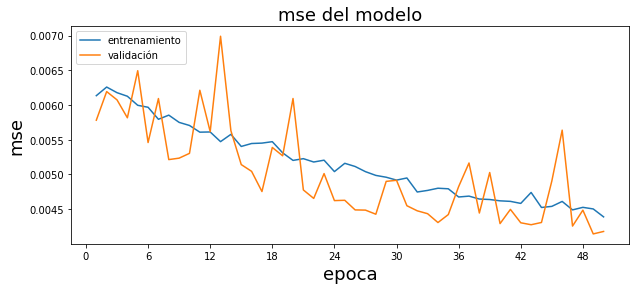


Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse did not improve from 0.00414

Epoch 00001: val_mse improved from 0.00414 to 0.00411, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00411 to 0.00410, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00410

Epoch 00001: val_mse did not improve from 0.00410

Epoch 00001: val_mse did not improve from 0.00410

Epoch 00001: val_mse improved from 0.00410 to 0.00404, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00404

Epoch 00001: val_mse improved from 0.00404 to 0.00398,

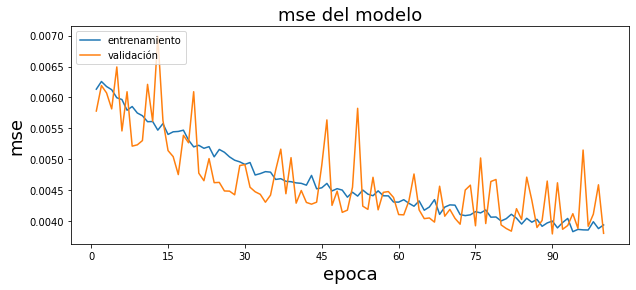


Epoch 00001: val_mse improved from 0.00379 to 0.00372, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve f

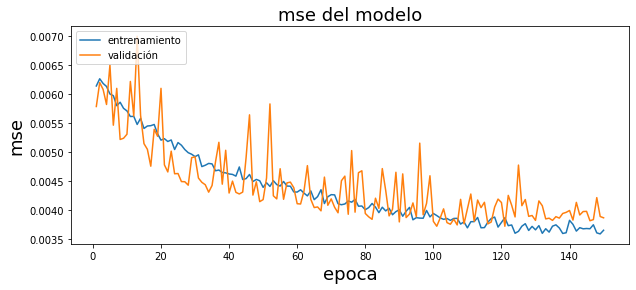


Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not improve from 0.00372

Epoch 00001: val_mse did not i

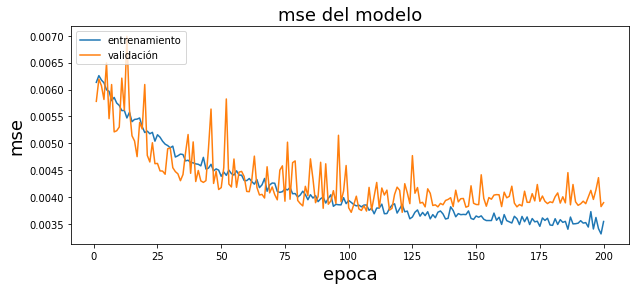

In [ ]:
epochs = 200
batch_size = 64
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [ ]:
model = load_model(modelpath) # recupero el mejor modelo en validación

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [ ]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()

In [ ]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

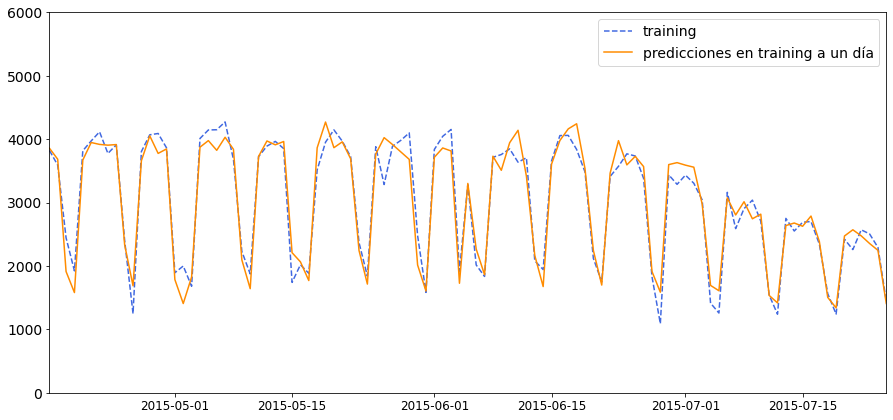

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[100],fechas_train[200],0,6000])
plt.legend(fontsize=14);

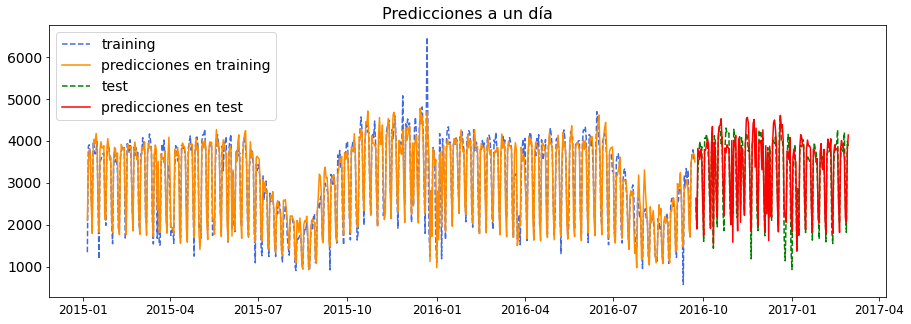

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

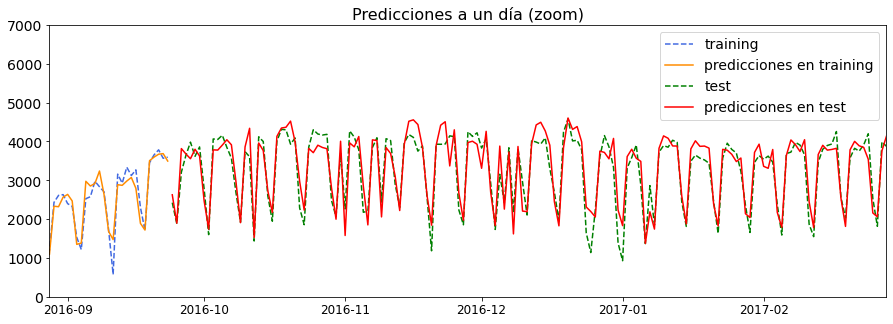

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[600],fechas_test[-1],0,7000]);

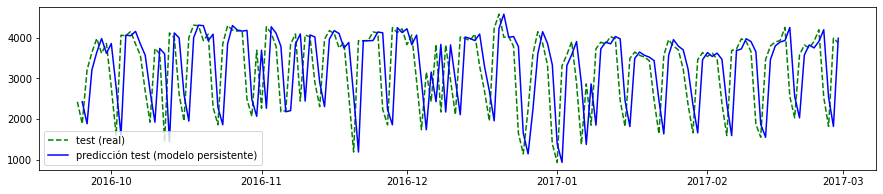

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test (real)')
plt.plot(fechas_test[1:], target_test[:-1], '-',   c='blue',
         label='predicción test (modelo persistente)')
plt.legend();

In [ ]:
# Modelos de referencia (en orden de complejidad):
# 1- Predecir siempre media (mediana) en training
# 2- Modelo persistente (a 1 día, 7 días etc.)
# 3- SARIMAX


# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.9101299594909013
R2 del modelo en test          :  0.8446697119780229
R2 modelo persistente 1 día    :  -0.44768351889101354
R2 modelo persistente 1 semana :  0.3743300534633949
R2 modelo persistente 4 semanas:  0.48525679455105053
R2 modelo persistente 1 año:  0.6779203301147232


In [ ]:
# RMSEs
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  383.97837552237206
RMSE del modelo en test          :  428.12053496589294
RMSE modelo persistente 1 día    :  1093.8023843688381
RMSE modelo persistente 1 semana :  724.5713553588926
RMSE modelo persistente 4 semanas:  654.1568971996292


## <font color="#CA3532"> **9. Predicciones a varios días en test mediante un modelo generativo**

In [ ]:
def step_generativo(model, ventana, X, i):
    # ventana: va a tener dimensiones (1, lookback, n_variables)
    # El target está en (0,:,0)
    # La posición (0,0,0) es el target en el día más antiguo de la ventana
    # La posición (0,0,-1) es el target en el día más reciente de la ventana
    # Las variables calendario están en (0,:,1:)
    # Las variables calendario para el último día de la ventana están en (0,-1,1:)

    z = model.predict(ventana)[0,0] # predicción nueva
    target_pred = inverse_transform(z)
    ventana_nueva = None
    if i < (len(X)-1):
        ventana_nueva = np.zeros(ventana.shape)
        # muevo un día hacia atrás todas las variables de la ventana:
        ventana_nueva[0,:-1,:] = ventana[0,1:,:].copy()

        # introduzco las variables calendario para el último día de la ventana:
        ventana_nueva[0,-1,1:] = X[i+1,-1,1:]

        # meto la predicción como última obervación del target:
        ventana_nueva[0,-1,0] = z
        
        
    return target_pred, ventana_nueva

In [ ]:
def generativo(model, X):
    ventana = np.array([X[0]]).copy()    
    salidas = []
    for i in range(len(X)):
        target_pred, ventana_nueva = step_generativo(model, ventana, X, i)
        salidas.append(target_pred)
        ventana = ventana_nueva
    
    return salidas

In [ ]:
sal = generativo(model, X_test)

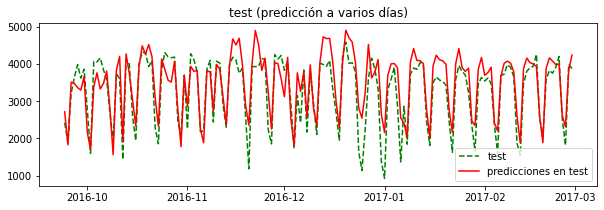

In [ ]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_test, target_test, '--g', label='test')
plt.plot(fechas_test, sal, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();

### **"Heatmaps" de la predicción: ¿qué inputs han influido más en la predicción?**

In [ ]:
print(nombres_series)
print(len(nombres_series))
print(X_test.shape)

['target_transf', 'festivo', 'coords_x_mes', 'coords_y_mes', 'coords_x_semana', 'coords_y_semana', 'coords_x_day_of_week', 'coords_y_day_of_week']
8
(158, 5, 8)


In [ ]:
len(se_saben_antes)

8

In [ ]:
i = 0
print(fechas_test[i]) # 24/09/2016 fue sábado
sample = X_test[i:(i+1)].copy()
sample.shape

2016-09-24T00:00:00.000000000


(1, 5, 8)

In [ ]:
info_enventanado(X_test[i:(i+1)],y[i:(i+1)],
                 nombres_series=nombres_series,
                 nombre_target="target_transf",
                 tiempos=fechas_test[i:(i+1)])

1 ventanas creadas

X.shape=(1, 5, 8)  Y.shape=(1,) 

 Ventana 0: 


X[0].shape=(5, 8) ?0 ?1 ?2 ?3 ?4 
 
 target_transf 
 0.690600 
 0.731000 
 0.757000 
 0.713400 
 0.719400 
 
 
 festivo 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 coords_x_mes 
 -0.000000 
 -0.000000 
 -0.000000 
 -0.000000 
 -0.000000 
 
 
 coords_y_mes 
 -1.000000 
 -1.000000 
 -1.000000 
 -1.000000 
 -1.000000 
 
 
 coords_x_semana 
 -0.500000 
 -0.500000 
 -0.500000 
 -0.500000 
 -0.500000 
 
 
 coords_y_semana 
 0.866025 
 0.866025 
 -0.866025 
 -0.866025 
 -0.866025 
 
 
 coords_x_day_of_week 
 0.623490 
 -0.222521 
 -0.900969 
 -0.900969 
 -0.222521 
 
 
 coords_y_day_of_week 
 0.781831 
 0.974928 
 0.433884 
 -0.433884 
 -0.974928 
 
 __ Y[0]=0.225 2016-09-24 00:00:00 
 
 target_transf 
 0.225000

In [ ]:
pred0 = model.predict(sample)[0][0]
delta = 1e-3
w_in = sample.shape[1]

print("SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:\n")
for i,x in enumerate(nombres_series):
    for j in range(w_in):
        sample_pert = sample.copy()
        sample_pert[0,j,i] += delta
        pred_pert = model.predict(sample_pert)[0][0]
        if se_saben_antes[i]:
            print("{} (t-{}) [ADELANTADA]: {:.3f}".format(x, w_in-j, (pred_pert - pred0) / delta))
        else:
            print("{} (t-{}): {:.3f}".format(x, w_in-j, (pred_pert - pred0) / delta))

SENSIBILIDAD DE LA PREDICCIÓN A LAS ENTRADAS:

target_transf (t-5): 0.035
target_transf (t-4): 0.105
target_transf (t-3): 0.192
target_transf (t-2): 0.009
target_transf (t-1): 0.135
festivo (t-5) [ADELANTADA]: 0.091
festivo (t-4) [ADELANTADA]: 0.144
festivo (t-3) [ADELANTADA]: 0.013
festivo (t-2) [ADELANTADA]: 0.073
festivo (t-1) [ADELANTADA]: -0.273
coords_x_mes (t-5) [ADELANTADA]: -0.001
coords_x_mes (t-4) [ADELANTADA]: 0.052
coords_x_mes (t-3) [ADELANTADA]: 0.041
coords_x_mes (t-2) [ADELANTADA]: -0.188
coords_x_mes (t-1) [ADELANTADA]: 0.139
coords_y_mes (t-5) [ADELANTADA]: 0.022
coords_y_mes (t-4) [ADELANTADA]: -0.025
coords_y_mes (t-3) [ADELANTADA]: -0.132
coords_y_mes (t-2) [ADELANTADA]: 0.083
coords_y_mes (t-1) [ADELANTADA]: -0.040
coords_x_semana (t-5) [ADELANTADA]: 0.002
coords_x_semana (t-4) [ADELANTADA]: 0.003
coords_x_semana (t-3) [ADELANTADA]: -0.036
coords_x_semana (t-2) [ADELANTADA]: 0.043
coords_x_semana (t-1) [ADELANTADA]: -0.048
coords_y_semana (t-5) [ADELANTADA]: 0.01

### **Función que saca por pantalla todos los parámetros de todas las capas de la red**

In [ ]:
def info_red(modelo):
    for i,layer in enumerate(modelo.layers):
        print('* Capa {} [Nombre: "{}"]'.format(i,layer.name))
        print('  Tipo:', type(layer))
        print("  Propiedades:")
        aux = layer.get_config()
        for k in aux:
            print("    {}: {}".format(k, aux[k]))
        print()

In [ ]:
# información detallada de todos los parámetros de cada capa del modelo:
info_red(model)

* Capa 0 [Nombre: "conv1d"]
  Tipo: <class 'keras.layers.convolutional.Conv1D'>
  Propiedades:
    name: conv1d
    trainable: True
    batch_input_shape: (None, 5, 8)
    dtype: float32
    filters: 4
    kernel_size: (3,)
    strides: (1,)
    padding: valid
    data_format: channels_last
    dilation_rate: (1,)
    groups: 1
    activation: relu
    use_bias: True
    kernel_initializer: {'class_name': 'GlorotUniform', 'config': {'seed': None}}
    bias_initializer: {'class_name': 'Zeros', 'config': {}}
    kernel_regularizer: None
    bias_regularizer: None
    activity_regularizer: None
    kernel_constraint: None
    bias_constraint: None

* Capa 1 [Nombre: "conv1d_1"]
  Tipo: <class 'keras.layers.convolutional.Conv1D'>
  Propiedades:
    name: conv1d_1
    trainable: True
    dtype: float32
    filters: 4
    kernel_size: (3,)
    strides: (1,)
    padding: valid
    data_format: channels_last
    dilation_rate: (1,)
    groups: 1
    activation: relu
    use_bias: True
    kern